In [1]:
import re
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Open the JSON file
resume_data_list = []
with open('Resume.json', 'r', encoding='utf-8') as file:
    for line in file:
        resume_data = json.loads(line)
        print(resume_data)
        resume_data_list.append(resume_data)

# Convert the list of dictionaries into a DataFrame
resume_df = pd.DataFrame(resume_data_list)

{'content': 'Govardhana K\nSenior Software Engineer\n\nBengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/\nb2de315d95905b68\n\nTotal IT experience 5 Years 6 Months\nCloud Lending Solutions INC 4 Month • Salesforce Developer\nOracle 5 Years 2 Month • Core Java Developer\nLanguages Core Java, Go Lang\nOracle PL-SQL programming,\nSales Force Developer with APEX.\n\nDesignations & Promotions\n\nWilling to relocate: Anywhere\n\nWORK EXPERIENCE\n\nSenior Software Engineer\n\nCloud Lending Solutions -  Bangalore, Karnataka -\n\nJanuary 2018 to Present\n\nPresent\n\nSenior Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2016 to December 2017\n\nStaff Consultant\n\nOracle -  Bangalore, Karnataka -\n\nJanuary 2014 to October 2016\n\nAssociate Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2012 to December 2013\n\nEDUCATION\n\nB.E in Computer Science Engineering\n\nAdithya Institute of Technology -  Tamil Nadu\n\nSeptember 2008 to June 2012\n\n

In [3]:
resume_df

,content,annotation
0,Govardhana K\nSenior Software Engineer\n\nBeng...,"[{'label': ['Companies worked at'], 'points': ..."
1,"Harini Komaravelli\nTest Analyst at Oracle, Hy...","[{'label': ['Companies worked at'], 'points': ..."
2,Hartej Kathuria\nData Analyst Intern - Oracle ...,"[{'label': ['Skills'], 'points': [{'start': 22..."
3,Ijas Nizamuddin\nAssociate Consultant - State ...,"[{'label': ['Skills'], 'points': [{'start': 46..."
4,"Imgeeyaul Ansari\njava developer\n\nPune, Maha...","[{'label': ['Skills'], 'points': [{'start': 18..."
...,...,...
195,"Mansi Thanki\nStudent\n\nJamnagar, Gujarat - E...","[{'label': ['College Name'], 'points': [{'star..."
196,Anil Kumar\nMicrosoft Azure (Basic Management)...,"[{'label': ['Location'], 'points': [{'start': ..."
197,Siddharth Choudhary\nMicrosoft Office Suite - ...,"[{'label': ['Skills'], 'points': [{'start': 78..."
198,Valarmathi Dhandapani\nInvestment Banking Oper...,"[{'label': ['Skills'], 'points': [{'start': 92..."


In [4]:
# Extract useful information from 'content'
resume_df['Name'] = resume_df['content'].apply(lambda x: x.split('\n')[0])
resume_df['Designation'] = resume_df['content'].apply(lambda x: x.split('\n')[1])

# Function to extract specific details from 'annotation' for multiple companies
def extract_companies(annotation, label):
    companies = [item['points'][0]['text'] for item in annotation if label in item['label']]
    return list(set(companies)) if companies else None  # Convert to a set and back to list for deduplication

# Add this block to extract the 'Companies' column as a list
resume_df['Companies'] = resume_df['annotation'].apply(lambda x: extract_companies(x, 'Companies worked at'))

# Function to extract specific details from 'annotation'
def extract_info(annotation, label):
    for item in annotation:
        if label in item['label']:
            return item['points'][0]['text']
    return None

# Function to extract and save all the skills as a dictionary
def extract_skills(annotation):
    skills_text = ""
    for item in annotation:
        if 'Skills' in item['label']:
            section_text = item['points'][0]['text']
            skills_text += f"{section_text}\n\n"

    return skills_text.strip()

# Add this block to extract and save the 'Skills' as a dictionary
resume_df['Skills'] = resume_df['annotation'].apply(extract_skills)

resume_df['Graduation Year'] = resume_df['annotation'].apply(lambda x: extract_info(x, 'Graduation Year'))
resume_df['College Name'] = resume_df['annotation'].apply(lambda x: extract_info(x, 'College Name'))
resume_df['Degree'] = resume_df['annotation'].apply(lambda x: extract_info(x, 'Degree'))
resume_df['Location'] = resume_df['annotation'].apply(lambda x: extract_info(x, 'Location'))
resume_df['Years of Experience'] = resume_df['annotation'].apply(lambda x: extract_info(x, 'Years of Experience'))

# Drop the 'content' and 'annotation' columns
resume_df = resume_df.drop(['content', 'annotation'], axis=1)


In [5]:
resume_df

,Name,Designation,Companies,Skills,Graduation Year,College Name,Degree,Location,Years of Experience
0,Govardhana K,Senior Software Engineer,"[Oracle, Cloud Lending Solutions]","Languages: Core Java, Go Lang, Data Structures...",2012,Adithya Institute of Technology,B.E in Computer Science Engineering,Bengaluru,None
1,Harini Komaravelli,"Test Analyst at Oracle, Hyderabad",[Oracle],"Functional Testing, Blue Prism, Qtp",None,\nOsmania University\n,B.Sc. in Computer Science,Hyderabad,6 Yrs
2,Hartej Kathuria,Data Analyst Intern - Oracle Retail,[Oracle Retail\n],"Languages & Technologies: Python, R, SQL, NoSQ...",2016,Manipal University\n,B. Tech in Electrical and Electronics in Embed...,Bengaluru,None
3,Ijas Nizamuddin,Associate Consultant - State Street,"[Oracle Corporation, State Street\n]",Languages: Core Java\nFront end/GUI Tools prog...,2009,University College Of Engineering,Bachelor of Technology in Computer Science,Irinchayam B.O,None
4,Imgeeyaul Ansari,java developer,[Oracle Financial Software Services],"rogramming Languages :C/C++, angular, java, ja...",2009,Rashtriya Military School Bangalore,CBSE in Mathematics and English\n,Pune,None
...,...,...,...,...,...,...,...,...,...
195,Mansi Thanki,Student,None,,None,Government Engineering College Bhuj,BE in Environmental Engineering,Jamnagar,None
196,Anil Kumar,Microsoft Azure (Basic Management),None,"DATA BACKUP (1 year), EXCHANGE (1 year), LAN (...",None,None,None,Delhi,None
197,Siddharth Choudhary,Microsoft Office Suite - Expert,None,"AUDITING (Less than 1 year), CFA (Less than 1 ...",None,None,None,Hyderabad,None
198,Valarmathi Dhandapani,Investment Banking Operations/PMO,[Infosys BPO Ltd],"Excel (10+ years), Operations (7 years), Proje...",2002,Ramakrishna College,B.Sc. in Biochemistry in Biochemistry\n,Bengaluru,2004


In [6]:
resume_df.isnull().sum()

Name                     0
Designation              0
Companies               27
Skills                   0
Graduation Year        109
College Name            26
Degree                  23
Location                19
Years of Experience    168
dtype: int64

In [7]:
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name                 200 non-null    object
 1   Designation          200 non-null    object
 2   Companies            173 non-null    object
 3   Skills               200 non-null    object
 4   Graduation Year      91 non-null     object
 5   College Name         174 non-null    object
 6   Degree               177 non-null    object
 7   Location             181 non-null    object
 8   Years of Experience  32 non-null     object
dtypes: object(9)
memory usage: 14.2+ KB


In [8]:
# Define a function to calculate years of experience
def calculate_years_of_experience(row):
    current_year = datetime.datetime.now().year
    
    # If "Years of Experience" is provided, use it
    if row['Years of Experience'] is not None:

        pattern = r'^\d{4}$'  # Matches exactly four digits
        years_experience_YYYY = bool(re.match(pattern, str(row['Years of Experience'])))
        
        if years_experience_YYYY:
            graduation_year = int(row['Graduation Year'])
            row['Years of Experience'] = current_year - graduation_year
        
        else:
            integer_match = re.search(r'\d+', row['Years of Experience'])
        
            if integer_match:
            # Convert the matched text to an integer
                years_of_experience = int(integer_match.group())
                row['Graduation Year'] = current_year - years_of_experience
    
    # If "Graduation Year" is provided, calculate years of experience
    if row['Graduation Year'] is not None:
        graduation_year = int(row['Graduation Year'])
        return current_year - graduation_year
    
    
    return None  # If neither value is provided, return None

# Apply the function to your DataFrame
resume_df['Years of Experience'] = resume_df.apply(calculate_years_of_experience, axis=1)

In [9]:
resume_df[['Graduation Year', 'Years of Experience']]

,Graduation Year,Years of Experience
0,2012,12.0
1,2018,6.0
2,2016,8.0
3,2009,15.0
4,2009,15.0
...,...,...
195,None,NaN
196,None,NaN
197,None,NaN
198,2002,22.0


In [10]:
resume_df

,Name,Designation,Companies,Skills,Graduation Year,College Name,Degree,Location,Years of Experience
0,Govardhana K,Senior Software Engineer,"[Oracle, Cloud Lending Solutions]","Languages: Core Java, Go Lang, Data Structures...",2012,Adithya Institute of Technology,B.E in Computer Science Engineering,Bengaluru,12.0
1,Harini Komaravelli,"Test Analyst at Oracle, Hyderabad",[Oracle],"Functional Testing, Blue Prism, Qtp",2018,\nOsmania University\n,B.Sc. in Computer Science,Hyderabad,6.0
2,Hartej Kathuria,Data Analyst Intern - Oracle Retail,[Oracle Retail\n],"Languages & Technologies: Python, R, SQL, NoSQ...",2016,Manipal University\n,B. Tech in Electrical and Electronics in Embed...,Bengaluru,8.0
3,Ijas Nizamuddin,Associate Consultant - State Street,"[Oracle Corporation, State Street\n]",Languages: Core Java\nFront end/GUI Tools prog...,2009,University College Of Engineering,Bachelor of Technology in Computer Science,Irinchayam B.O,15.0
4,Imgeeyaul Ansari,java developer,[Oracle Financial Software Services],"rogramming Languages :C/C++, angular, java, ja...",2009,Rashtriya Military School Bangalore,CBSE in Mathematics and English\n,Pune,15.0
...,...,...,...,...,...,...,...,...,...
195,Mansi Thanki,Student,None,,None,Government Engineering College Bhuj,BE in Environmental Engineering,Jamnagar,NaN
196,Anil Kumar,Microsoft Azure (Basic Management),None,"DATA BACKUP (1 year), EXCHANGE (1 year), LAN (...",None,None,None,Delhi,NaN
197,Siddharth Choudhary,Microsoft Office Suite - Expert,None,"AUDITING (Less than 1 year), CFA (Less than 1 ...",None,None,None,Hyderabad,NaN
198,Valarmathi Dhandapani,Investment Banking Operations/PMO,[Infosys BPO Ltd],"Excel (10+ years), Operations (7 years), Proje...",2002,Ramakrishna College,B.Sc. in Biochemistry in Biochemistry\n,Bengaluru,22.0


Column: Years of Experience


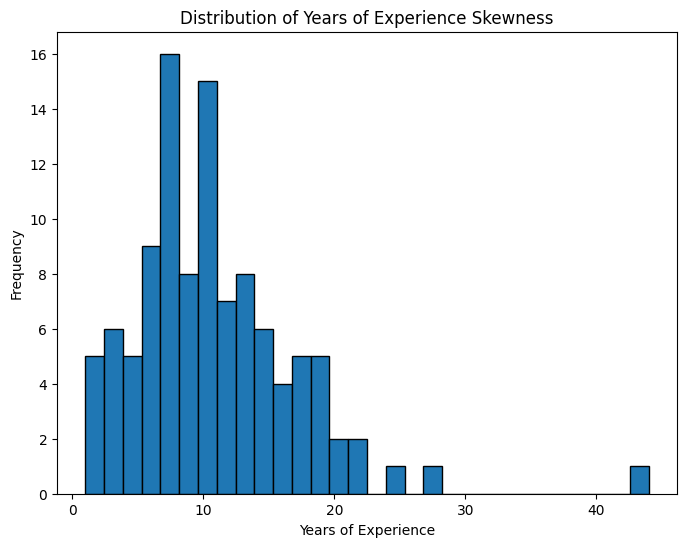

In [11]:
# Assuming your DataFrame is named 'resume_df'
numeric_columns = resume_df.select_dtypes(include=[np.number]).columns

for column in numeric_columns:
    print(f"Column: {column}")
    
    # Step 2: Detect outliers
    z_scores = np.abs(stats.zscore(resume_df[column]))
    outliers = resume_df[np.abs(z_scores) > 3]

    # Step 3: Calculate skewness
    skewness = stats.skew(resume_df[column])

    # Step 3: Visualize the distribution
    plt.figure(figsize=(8, 6))
    plt.hist(resume_df[column].dropna(), bins=30, edgecolor='k')
    plt.title(f'Distribution of {column} Skewness')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [12]:
nan_years_names = resume_df[resume_df['Years of Experience'].isna()]['Name'].to_list()

In [13]:
# Extract names from the resume_data_list that match the names in nan_years_names
matching_names_data = [data for data in resume_data_list if data['content'].split('\n')[0] in nan_years_names]


In [14]:
len(matching_names_data)

94

In [15]:
years_of_experience_dict = {}

for item in matching_names_data:
    name = [item['points'][0]['text'] for item in item['annotation'] if 'Name' in item['label']]
    text = item['content']

    # Search for patterns like "Total IT experience 5 Years 6 Months"
    matches = re.findall(r"Total IT experience (\d+) Years (\d+) Months", text)
    if matches:
        years, months = map(int, matches[0])
        total_experience = years + months / 12
        years_of_experience_dict[name] = total_experience
    else:
        # Search for patterns like "December 2016 to Present"
        matches = re.findall(r"(\w+ \d{4}) to Present", text)
        if matches:
            start_date = matches[0]
            start_year = int(re.findall(r"\d{4}", start_date)[0])
            current_year = 2023  # You can update this to the current year
            total_experience = current_year - start_year
            years_of_experience_dict[name[0]] = total_experience

print(years_of_experience_dict)

{'Karthihayini C': 7, 'Lakshika Neelakshi': 5, 'Pratibha P': 11, 'Prem Koshti': 21, 'Sameer Kujur': 7, 'Senthil Kumar': 8, 'Sivaganesh Selvakumar': 7, 'Snehal Jadhav\n': 6, 'Tejasri Gunnam': 11, 'Vijayalakshmi Govindarajan': 11, 'Viny Khandelwal': 8, 'Asha Subbaiah': 9, 'Ramesh chokkala': 5, 'Tanmoy Maity': 8, 'Chhaya Prabhale': 17, 'Karthik G V': 18, 'Mohammed Murtuza': 7, 'Prabhu Prasad Mohapatra': 5, 'Raja Chandra Mouli': 5, 'Dushyant Bhatt': 8, 'pradeep chauhan': 6, 'Rishabh soni': 5, 'Karan Turkar': 7, 'Laya A': 6, 'Vishwanath P': 7, 'Praveen Bhaskar': 7, 'Puneeth R': 8, 'Kandrapu Reddy': 7, 'Vineeth Vijayan': 7, 'Dilliraja Baskara': 8, 'Yogesh Ghatole': 6, 'Shaik Tazuddin': 6, 'Angad Waghmare': 7, 'Sohan Dhakad': 7, 'Shreya Agnihotri': 7, 'Arpit Jain': 7, 'Jatin Arora': 6, 'Karthik Gururaj': 6, 'Akila Mohideen': 8, 'Nitin Verma': 6, 'Shivasai Mantri': 7, 'Vinay Singhal': 5, 'Shivam Sharma': 7, 'Gaikwad Dilip': 6, 'Pradeep Kumar': 8}


In [16]:
# Iterate through the DataFrame and update 'Years of Experience' where the name matches
for name, experience in years_of_experience_dict.items():
    resume_df.loc[resume_df['Name'] == name, 'Years of Experience'] = experience

In [17]:
resume_df

,Name,Designation,Companies,Skills,Graduation Year,College Name,Degree,Location,Years of Experience
0,Govardhana K,Senior Software Engineer,"[Oracle, Cloud Lending Solutions]","Languages: Core Java, Go Lang, Data Structures...",2012,Adithya Institute of Technology,B.E in Computer Science Engineering,Bengaluru,12.0
1,Harini Komaravelli,"Test Analyst at Oracle, Hyderabad",[Oracle],"Functional Testing, Blue Prism, Qtp",2018,\nOsmania University\n,B.Sc. in Computer Science,Hyderabad,6.0
2,Hartej Kathuria,Data Analyst Intern - Oracle Retail,[Oracle Retail\n],"Languages & Technologies: Python, R, SQL, NoSQ...",2016,Manipal University\n,B. Tech in Electrical and Electronics in Embed...,Bengaluru,8.0
3,Ijas Nizamuddin,Associate Consultant - State Street,"[Oracle Corporation, State Street\n]",Languages: Core Java\nFront end/GUI Tools prog...,2009,University College Of Engineering,Bachelor of Technology in Computer Science,Irinchayam B.O,15.0
4,Imgeeyaul Ansari,java developer,[Oracle Financial Software Services],"rogramming Languages :C/C++, angular, java, ja...",2009,Rashtriya Military School Bangalore,CBSE in Mathematics and English\n,Pune,15.0
...,...,...,...,...,...,...,...,...,...
195,Mansi Thanki,Student,None,,None,Government Engineering College Bhuj,BE in Environmental Engineering,Jamnagar,NaN
196,Anil Kumar,Microsoft Azure (Basic Management),None,"DATA BACKUP (1 year), EXCHANGE (1 year), LAN (...",None,None,None,Delhi,NaN
197,Siddharth Choudhary,Microsoft Office Suite - Expert,None,"AUDITING (Less than 1 year), CFA (Less than 1 ...",None,None,None,Hyderabad,NaN
198,Valarmathi Dhandapani,Investment Banking Operations/PMO,[Infosys BPO Ltd],"Excel (10+ years), Operations (7 years), Proje...",2002,Ramakrishna College,B.Sc. in Biochemistry in Biochemistry\n,Bengaluru,22.0


In [18]:
resume_df.isna().sum()

Name                    0
Designation             0
Companies              27
Skills                  0
Graduation Year        94
College Name           26
Degree                 23
Location               19
Years of Experience    50
dtype: int64

## 1. Handling Missing Values:

In [19]:
# Define numerical and categorical columns
numerical_cols = ['Graduation Year', 'Years of Experience']
categorical_cols = ['Location', 'Designation', 'Companies', 'Skills', 'College Name', 'Degree']

# Replace None values with NaN for consistent imputation
resume_df[categorical_cols] = resume_df[categorical_cols].replace({None: np.nan})

# Impute missing values with mean for numerical columns
imputer_mean = SimpleImputer(strategy='mean')
resume_df[numerical_cols] = imputer_mean.fit_transform(resume_df[numerical_cols])

# Convert numerical columns to integers
resume_df[numerical_cols] = resume_df[numerical_cols].astype(int)

# Replace missing values in categorical columns with a placeholder value
placeholder_value = 'Unknown'
imputer_placeholder = SimpleImputer(strategy='constant', fill_value=placeholder_value)
resume_df[categorical_cols] = imputer_placeholder.fit_transform(resume_df[categorical_cols])

In [20]:
resume_df

,Name,Designation,Companies,Skills,Graduation Year,College Name,Degree,Location,Years of Experience
0,Govardhana K,Senior Software Engineer,"[Oracle, Cloud Lending Solutions]","Languages: Core Java, Go Lang, Data Structures...",2012,Adithya Institute of Technology,B.E in Computer Science Engineering,Bengaluru,12
1,Harini Komaravelli,"Test Analyst at Oracle, Hyderabad",[Oracle],"Functional Testing, Blue Prism, Qtp",2018,\nOsmania University\n,B.Sc. in Computer Science,Hyderabad,6
2,Hartej Kathuria,Data Analyst Intern - Oracle Retail,[Oracle Retail\n],"Languages & Technologies: Python, R, SQL, NoSQ...",2016,Manipal University\n,B. Tech in Electrical and Electronics in Embed...,Bengaluru,8
3,Ijas Nizamuddin,Associate Consultant - State Street,"[Oracle Corporation, State Street\n]",Languages: Core Java\nFront end/GUI Tools prog...,2009,University College Of Engineering,Bachelor of Technology in Computer Science,Irinchayam B.O,15
4,Imgeeyaul Ansari,java developer,[Oracle Financial Software Services],"rogramming Languages :C/C++, angular, java, ja...",2009,Rashtriya Military School Bangalore,CBSE in Mathematics and English\n,Pune,15
...,...,...,...,...,...,...,...,...,...
195,Mansi Thanki,Student,Unknown,,2013,Government Engineering College Bhuj,BE in Environmental Engineering,Jamnagar,9
196,Anil Kumar,Microsoft Azure (Basic Management),Unknown,"DATA BACKUP (1 year), EXCHANGE (1 year), LAN (...",2013,Unknown,Unknown,Delhi,9
197,Siddharth Choudhary,Microsoft Office Suite - Expert,Unknown,"AUDITING (Less than 1 year), CFA (Less than 1 ...",2013,Unknown,Unknown,Hyderabad,9
198,Valarmathi Dhandapani,Investment Banking Operations/PMO,[Infosys BPO Ltd],"Excel (10+ years), Operations (7 years), Proje...",2002,Ramakrishna College,B.Sc. in Biochemistry in Biochemistry\n,Bengaluru,22


In [21]:
resume_df.isna().sum()

Name                   0
Designation            0
Companies              0
Skills                 0
Graduation Year        0
College Name           0
Degree                 0
Location               0
Years of Experience    0
dtype: int64

## 2. Handling Outliers:

In [22]:
# Define IQR thresholds
Q1 = resume_df[numerical_cols].quantile(0.25)
Q3 = resume_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using IQR
resume_df = resume_df[~((resume_df[numerical_cols] < (Q1 - 1.5 * IQR)) | (resume_df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [23]:
# Remove list brackets from 'Companies' column
resume_df['Companies'] = resume_df['Companies'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

C:\Users\User1\AppData\Local\Temp\ipykernel_30960\2660335629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['Companies'] = resume_df['Companies'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)


In [24]:
resume_df

,Name,Designation,Companies,Skills,Graduation Year,College Name,Degree,Location,Years of Experience
0,Govardhana K,Senior Software Engineer,"Oracle, Cloud Lending Solutions","Languages: Core Java, Go Lang, Data Structures...",2012,Adithya Institute of Technology,B.E in Computer Science Engineering,Bengaluru,12
7,Jyotirbindu Patnaik,"Associate consultant@SAP labs , Bangalore Karn...",Sap labs,ITIL foundation,2013,Biju Patnaik University,B. Tech in Electronics and Communication\n,Bengaluru,9
8,Karthihayini C,Systems Engineer - Infosys Limited,"Infosys Limited, Infosys Limited\n",Consistent\n\nHard working\n\n Flexible\n\nAbi...,2013,Hr. Sec. School\n,B E in Production Engineering,Rajapalaiyam,7
11,Kasturika Borah,Team Member - Cisco,Cisco,"• Programming Languages: Python, XML\n• Databa...",2012,rajasthan University\n,Unknown,Bengaluru,12
12,Kavitha K,Senior System Engineer - Infosys Limited,Infosys Limited\n,,2014,REiume Institute of road,Bachelor of Engineering in Information Technology,Salem,10
...,...,...,...,...,...,...,...,...,...
193,Moumita Mitra,- Email me on Indeed: indeed.com/r/Moumita-Mit...,Unknown,"Computer: Proficient in Windows, Word, Excel, ...",2013,St. Paul's Academy,C.B.S.E,Unknown,9
195,Mansi Thanki,Student,Unknown,,2013,Government Engineering College Bhuj,BE in Environmental Engineering,Jamnagar,9
196,Anil Kumar,Microsoft Azure (Basic Management),Unknown,"DATA BACKUP (1 year), EXCHANGE (1 year), LAN (...",2013,Unknown,Unknown,Delhi,9
197,Siddharth Choudhary,Microsoft Office Suite - Expert,Unknown,"AUDITING (Less than 1 year), CFA (Less than 1 ...",2013,Unknown,Unknown,Hyderabad,9


<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 0 to 199
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name                 122 non-null    object
 1   Designation          122 non-null    object
 2   Companies            122 non-null    object
 3   Skills               122 non-null    object
 4   Graduation Year      122 non-null    int32 
 5   College Name         122 non-null    object
 6   Degree               122 non-null    object
 7   Location             122 non-null    object
 8   Years of Experience  122 non-null    int32 
dtypes: int32(2), object(7)
memory usage: 8.6+ KB
None
       Graduation Year  Years of Experience
count       122.000000           122.000000
mean       2013.131148             8.762295
std           0.602348             1.841008
min        2012.000000             5.000000
25%        2013.000000             8.000000
50%        2013.000000             9.0

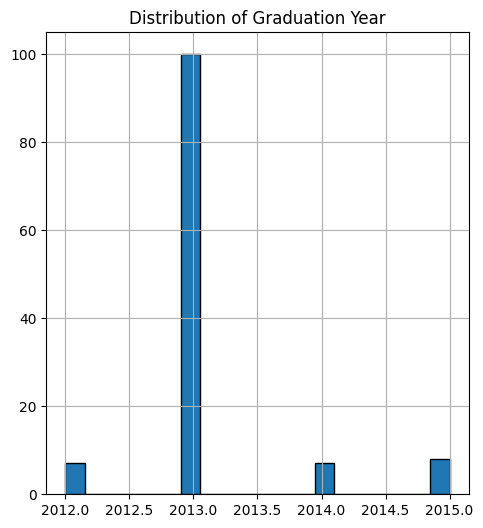

Unique values in Designation:
Microsoft Certified System Engineer                                               2
Senior System Engineer - Infosys Limited                                          2
Orrisha - Email me on Indeed: indeed.com/r/Sameer-Kujur/0771f65bfa7aff96          2
Senior Software Engineer                                                          1
Shivpuri, Madhya Pradesh - Email me on Indeed: indeed.com/r/Sohan-                1
                                                                                 ..
Technical Project Manager                                                         1
Self-employed in Family Business - SELF EMPLOYED                                  1
Tech Support Executive - Teleperformance for Microsoft                            1
Coimbatore - Email me on Indeed: indeed.com/r/Syed-Sadath-ali/cf3a21da22da956d    1
Security Analyst in Infosys - Career Contour                                      1
Name: Designation, Length: 119, dtype: int64



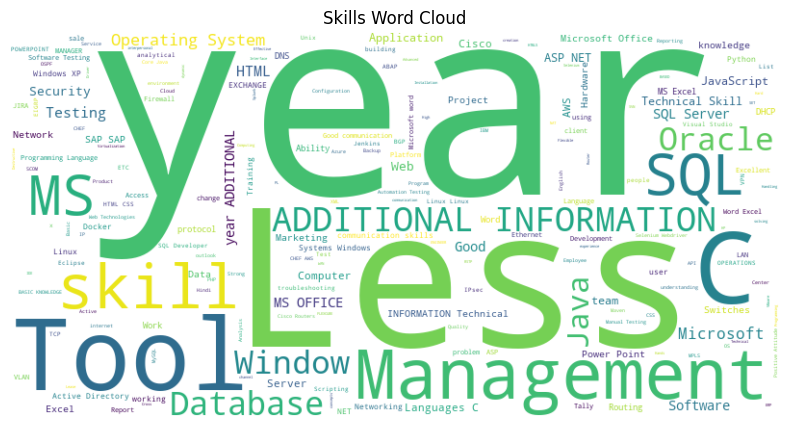

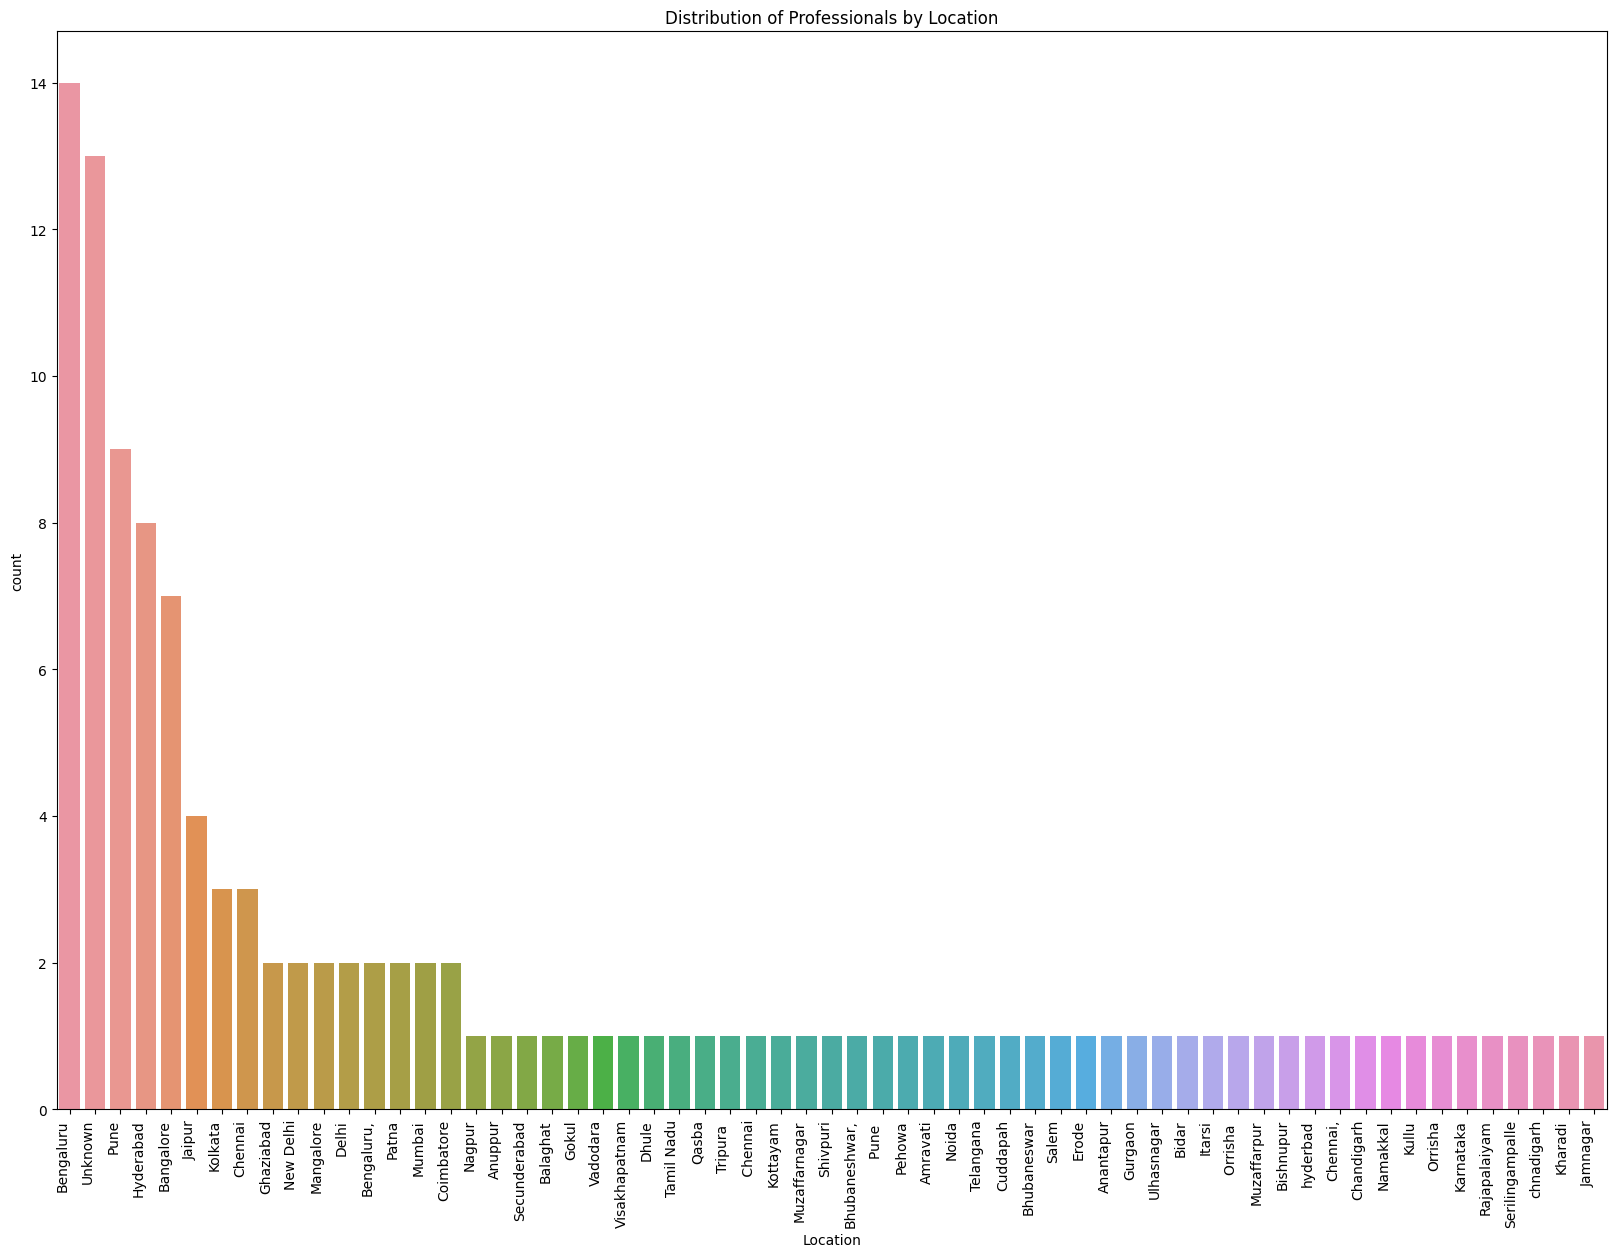

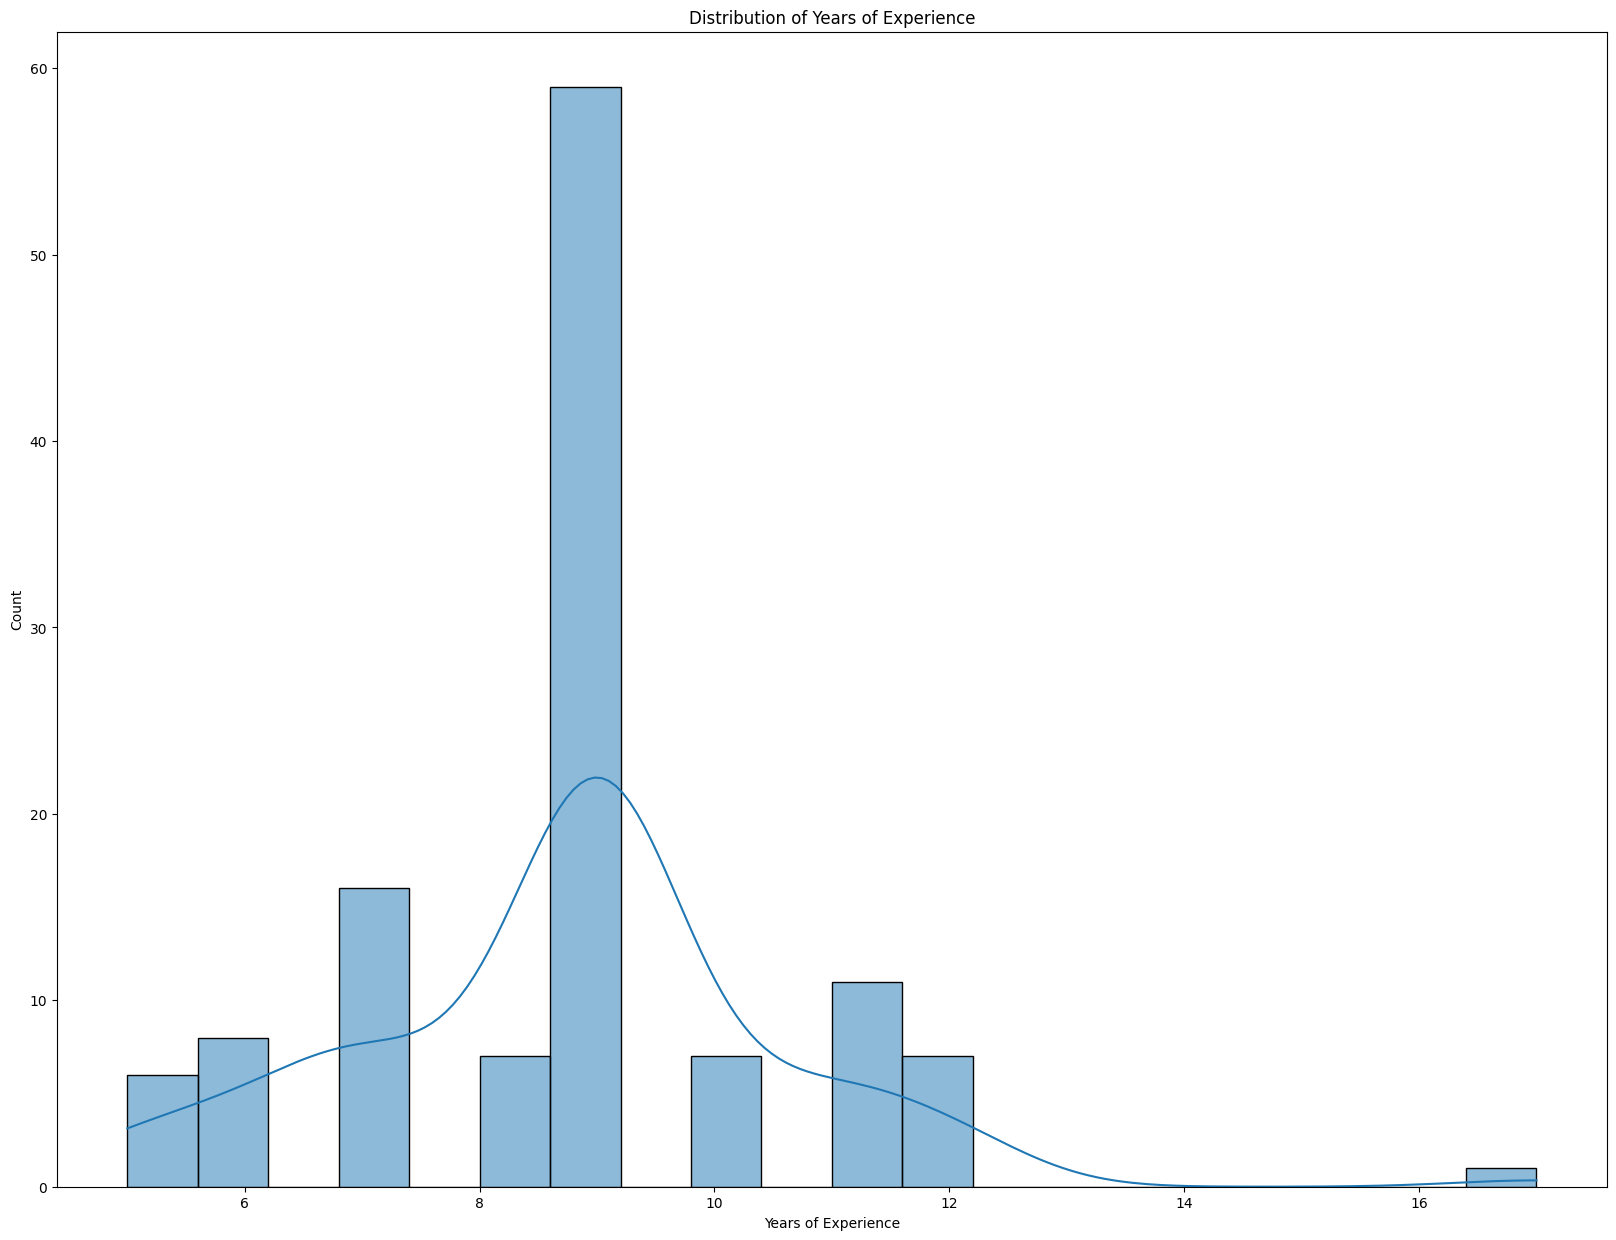

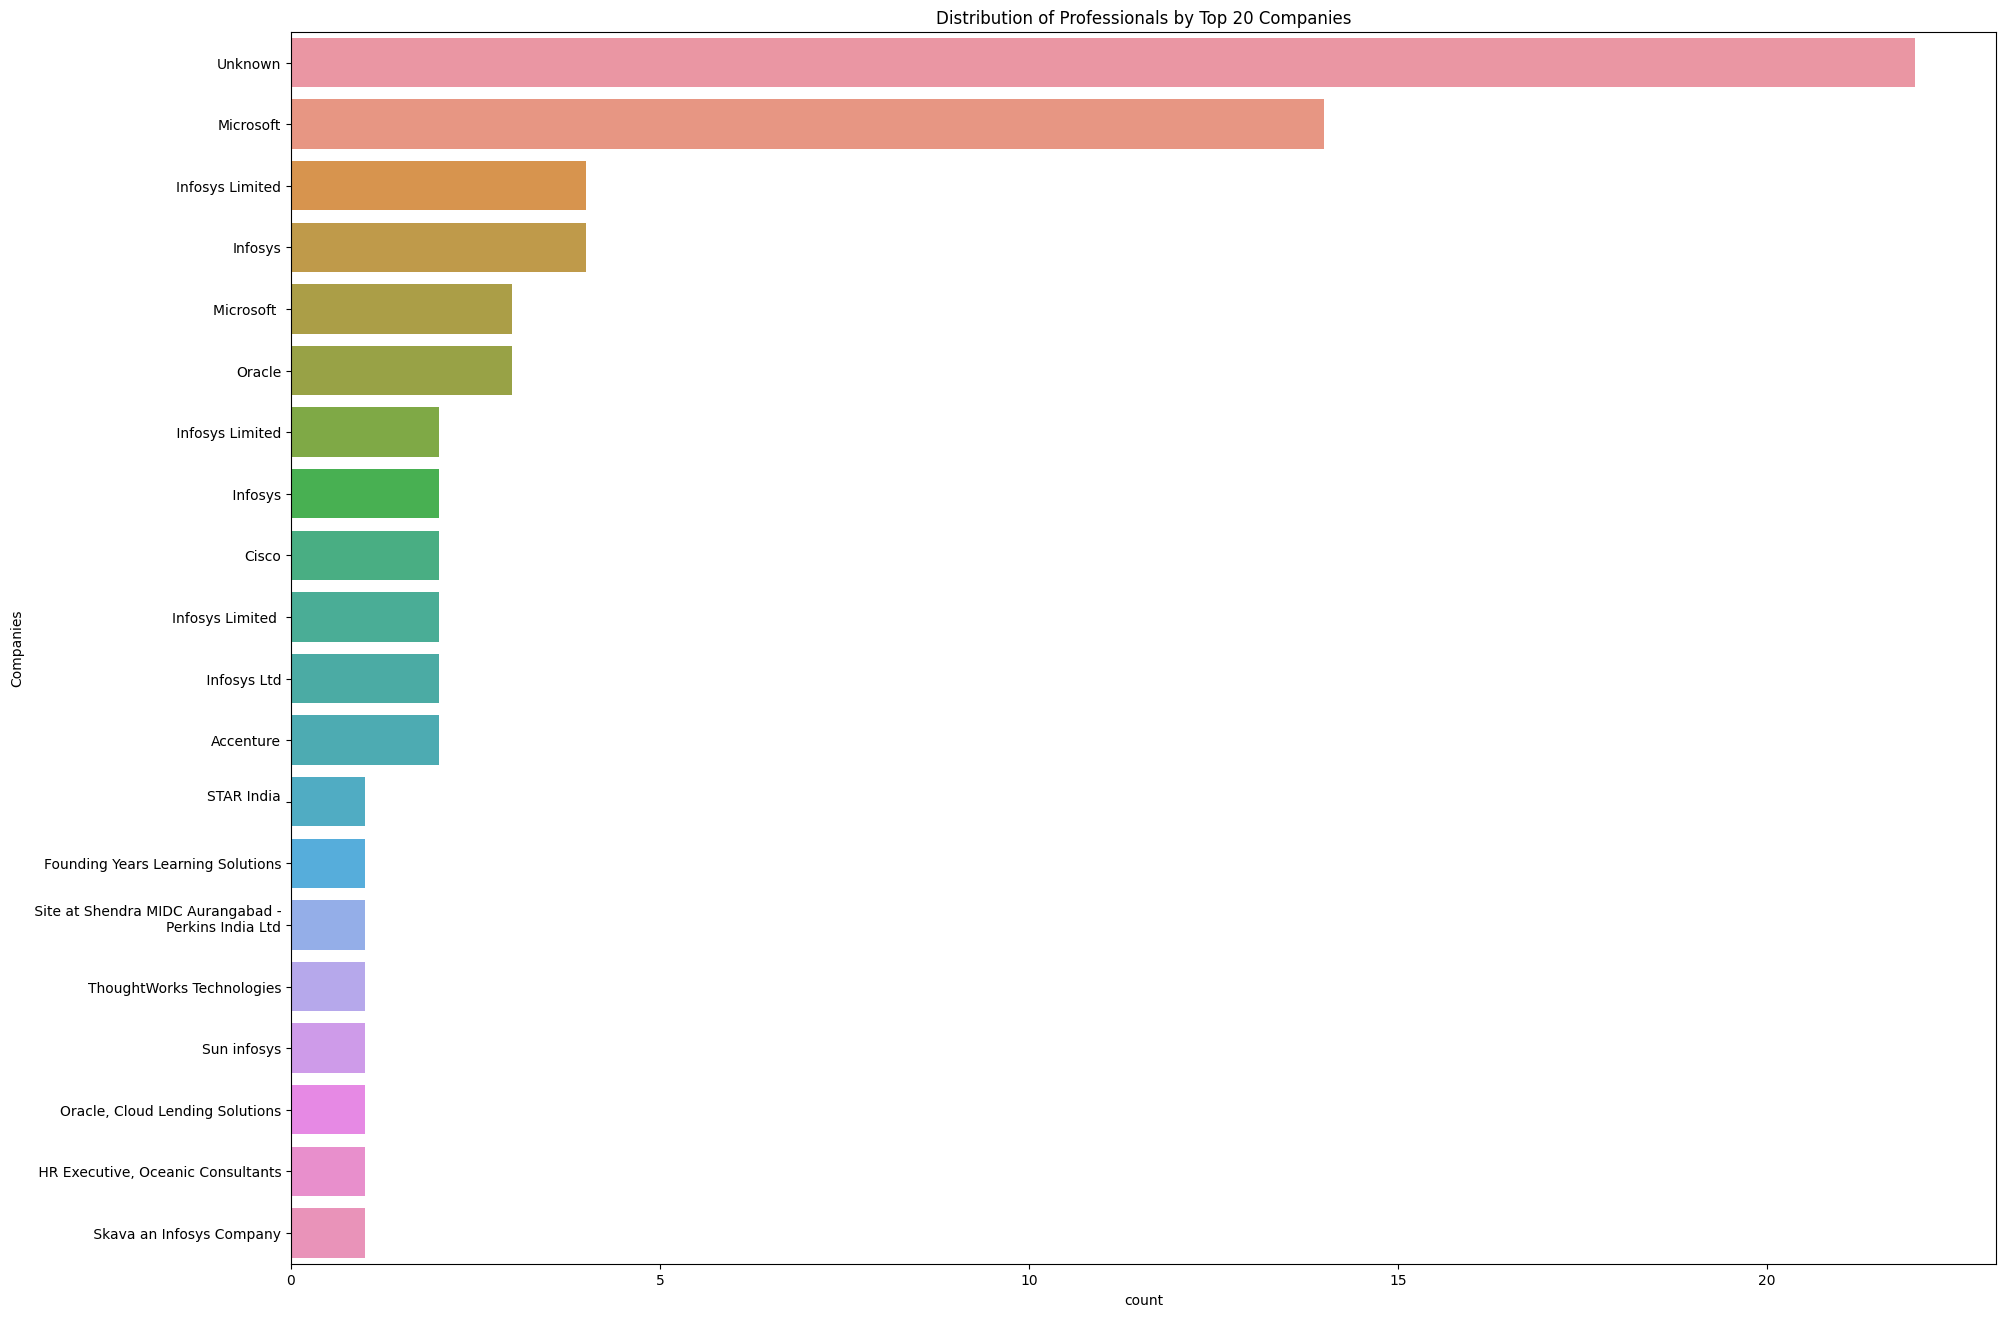

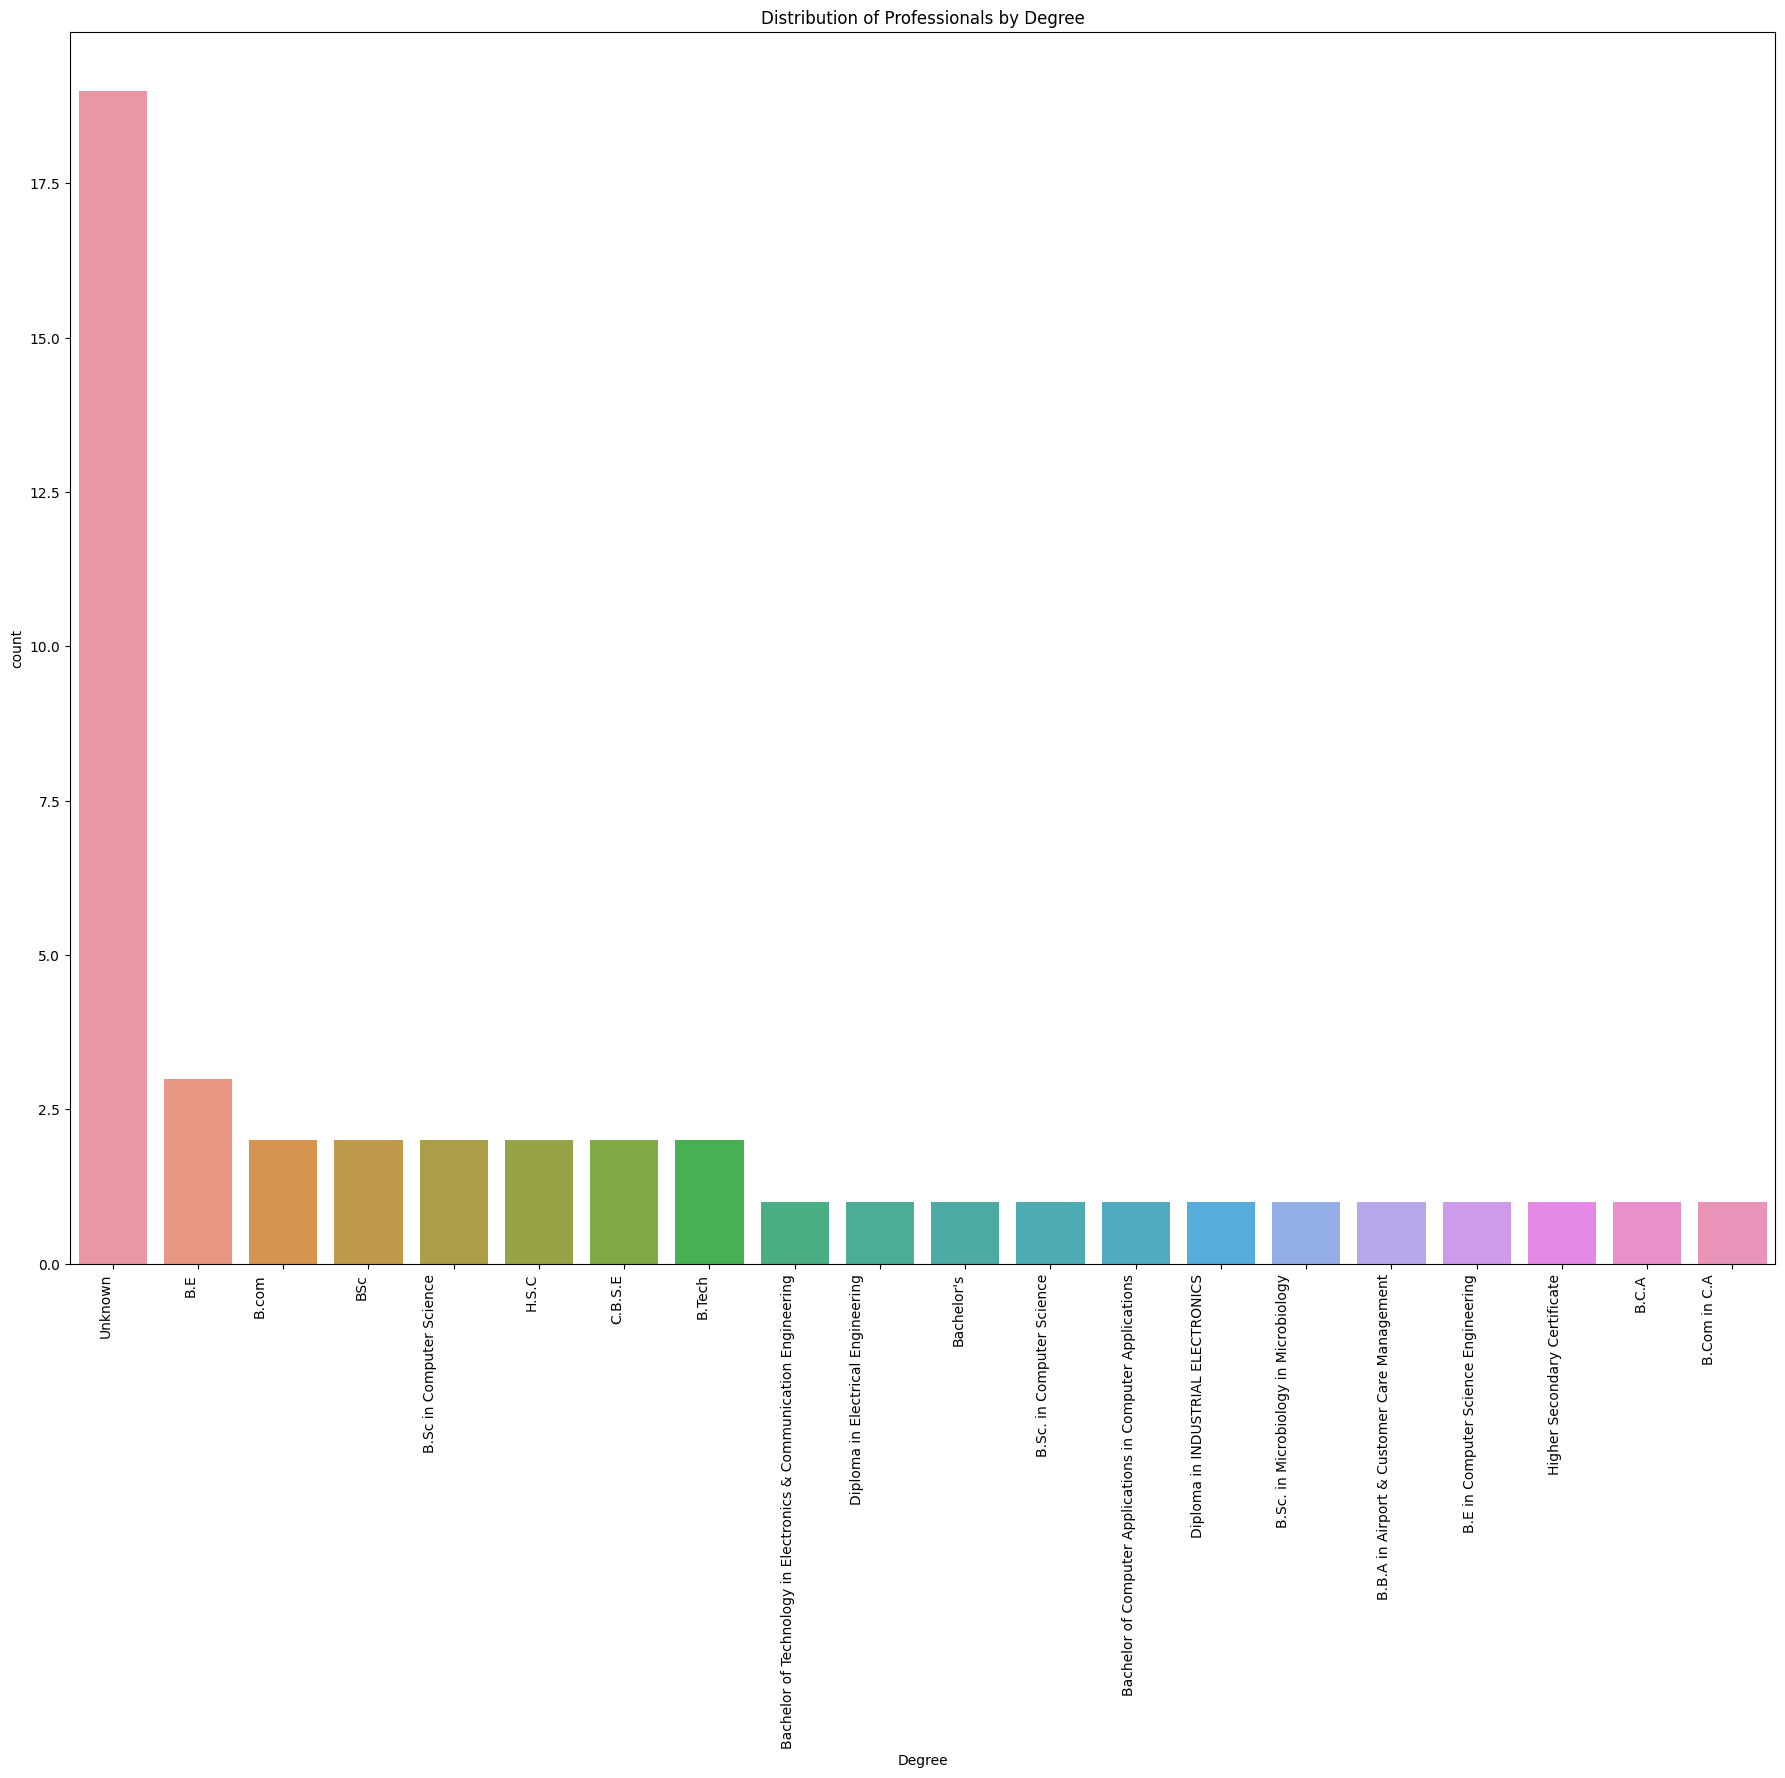

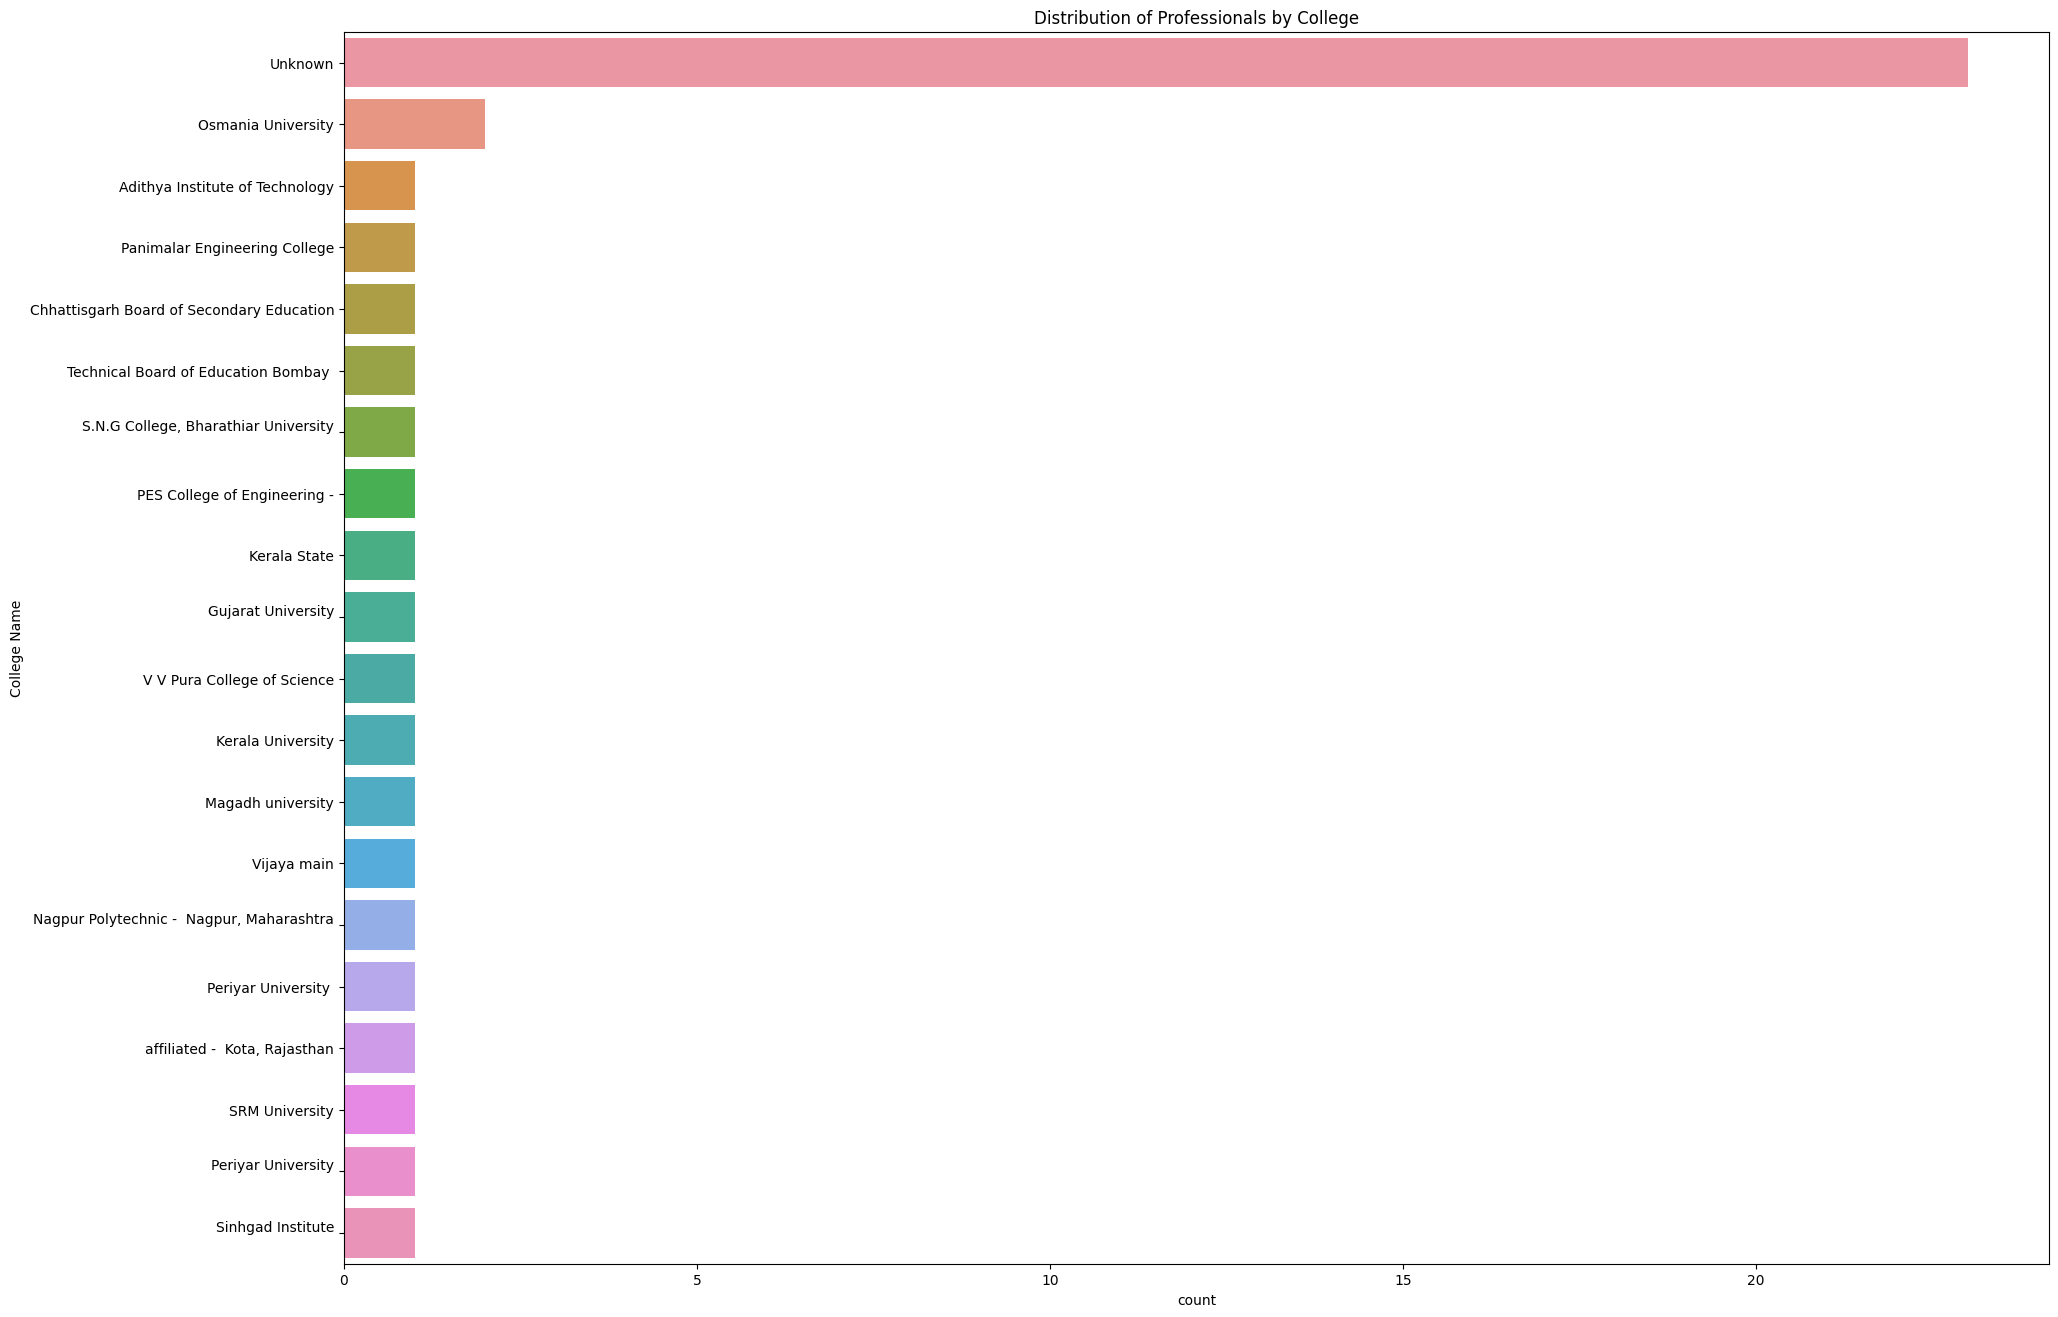

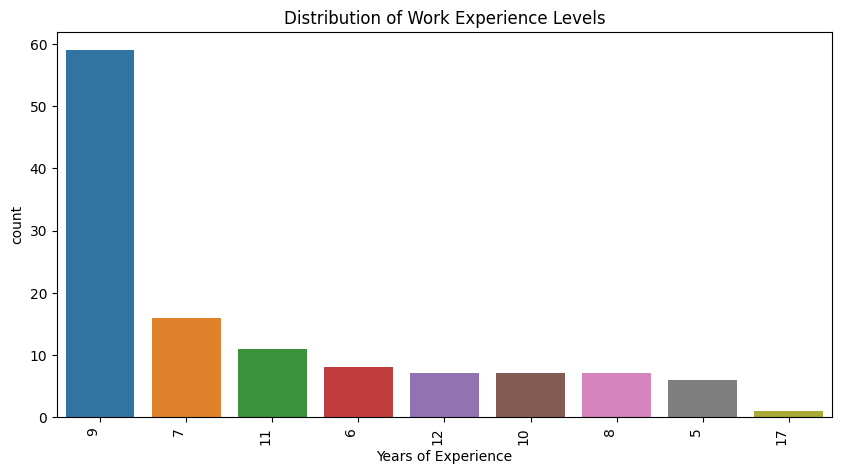

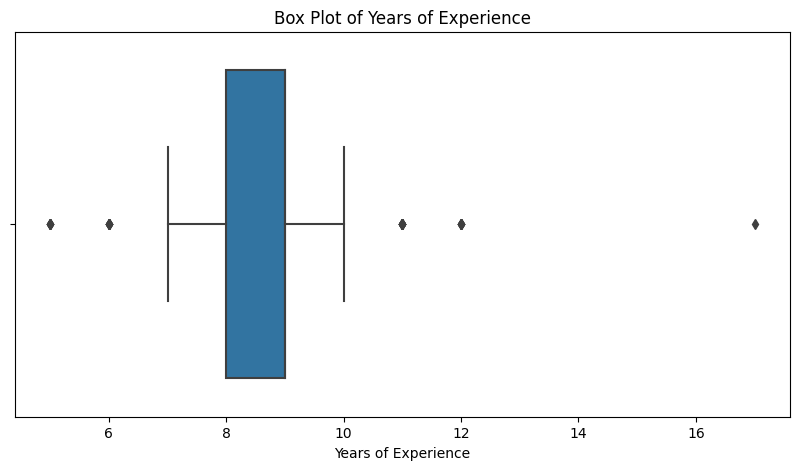

In [25]:
# Task 1: Summary Statistics
print(resume_df.info())
print(resume_df.describe())

# Task 2: Distribution of Numerical Features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
resume_df['Graduation Year'].hist(bins=20, edgecolor='k')
plt.title('Distribution of Graduation Year')

plt.show()

# Task 3: Categorical Feature Exploration
for col in ['Designation', 'Companies', 'Skills', 'College Name', 'Degree', 'Location']:
    print(f"Unique values in {col}:")
    print(resume_df[col].value_counts())
    print("\n")

# Task 4: Skills Analysis (Word Cloud)
skills_text = ' '.join(resume_df['Skills'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Skills Word Cloud')
plt.show()

# Task 5: Location Analysis
plt.figure(figsize=(20, 14))
sns.countplot(x='Location', data=resume_df, order=resume_df['Location'].value_counts().index)
plt.title('Distribution of Professionals by Location')
plt.xticks(rotation=90, ha='right')
plt.show()

# Task 6: Experience Analysis
plt.figure(figsize=(20, 15))
sns.histplot(resume_df['Years of Experience'], bins=20, kde=True)
plt.title('Distribution of Years of Experience')
plt.xlabel('Years of Experience')
plt.show()

# Task 7: Company Distribution (Top 20)
top_companies = resume_df['Companies'].explode().value_counts().nlargest(20)


plt.figure(figsize=(22, 16))
sns.countplot(y='Companies', data=resume_df, order=top_companies.index)
plt.title('Distribution of Professionals by Top 20 Companies')
plt.show()

# Task 8: Degree Distribution
top_degree = resume_df['Degree'].explode().value_counts().nlargest(20)

plt.figure(figsize=(22, 16))
sns.countplot(x='Degree', data=resume_df, order=top_degree.index)
plt.title('Distribution of Professionals by Degree')
plt.xticks(rotation=90, ha='right')
plt.show()

# Task 9: College Analysis
top_colleges = resume_df['College Name'].explode().value_counts().nlargest(20)

plt.figure(figsize=(22, 16))
sns.countplot(y='College Name', data=resume_df, order=top_colleges.index)
plt.title('Distribution of Professionals by College')
plt.show()

# Task 10: Visualization of Work Experience
plt.figure(figsize=(10, 5))
sns.countplot(x='Years of Experience', data=resume_df, order=resume_df['Years of Experience'].value_counts().index)
plt.title('Distribution of Work Experience Levels')
plt.xlabel('Years of Experience')
plt.xticks(rotation=90, ha='right')
plt.show()

# Task 11: Outliers Detection (Box Plot)
plt.figure(figsize=(10, 5))
sns.boxplot(x=resume_df['Years of Experience'])
plt.title('Box Plot of Years of Experience')
plt.show()

In [26]:
# Example: Creating an 'Experience Level' column
def experience_level(years):
    if years < 5:
        return 'Junior'
    elif 5 <= years < 10:
        return 'Mid-level'
    else:
        return 'Senior'

resume_df['Experience Level'] = resume_df['Years of Experience'].apply(experience_level)

C:\Users\User1\AppData\Local\Temp\ipykernel_30960\2918238819.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['Experience Level'] = resume_df['Years of Experience'].apply(experience_level)


In [27]:
resume_df

,Name,Designation,Companies,Skills,Graduation Year,College Name,Degree,Location,Years of Experience,Experience Level
0,Govardhana K,Senior Software Engineer,"Oracle, Cloud Lending Solutions","Languages: Core Java, Go Lang, Data Structures...",2012,Adithya Institute of Technology,B.E in Computer Science Engineering,Bengaluru,12,Senior
7,Jyotirbindu Patnaik,"Associate consultant@SAP labs , Bangalore Karn...",Sap labs,ITIL foundation,2013,Biju Patnaik University,B. Tech in Electronics and Communication\n,Bengaluru,9,Mid-level
8,Karthihayini C,Systems Engineer - Infosys Limited,"Infosys Limited, Infosys Limited\n",Consistent\n\nHard working\n\n Flexible\n\nAbi...,2013,Hr. Sec. School\n,B E in Production Engineering,Rajapalaiyam,7,Mid-level
11,Kasturika Borah,Team Member - Cisco,Cisco,"• Programming Languages: Python, XML\n• Databa...",2012,rajasthan University\n,Unknown,Bengaluru,12,Senior
12,Kavitha K,Senior System Engineer - Infosys Limited,Infosys Limited\n,,2014,REiume Institute of road,Bachelor of Engineering in Information Technology,Salem,10,Senior
...,...,...,...,...,...,...,...,...,...,...
193,Moumita Mitra,- Email me on Indeed: indeed.com/r/Moumita-Mit...,Unknown,"Computer: Proficient in Windows, Word, Excel, ...",2013,St. Paul's Academy,C.B.S.E,Unknown,9,Mid-level
195,Mansi Thanki,Student,Unknown,,2013,Government Engineering College Bhuj,BE in Environmental Engineering,Jamnagar,9,Mid-level
196,Anil Kumar,Microsoft Azure (Basic Management),Unknown,"DATA BACKUP (1 year), EXCHANGE (1 year), LAN (...",2013,Unknown,Unknown,Delhi,9,Mid-level
197,Siddharth Choudhary,Microsoft Office Suite - Expert,Unknown,"AUDITING (Less than 1 year), CFA (Less than 1 ...",2013,Unknown,Unknown,Hyderabad,9,Mid-level


In [28]:
# Assuming 'Experience Level' is your target variable
target_variable = 'Experience Level'

# Drop any columns that are not features or the target variable
X = resume_df.drop([target_variable], axis=1)
y = resume_df[target_variable]

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Encode the target variable if it's not numeric
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Base Model (Linear Model): Logistic Regression
base_model = LogisticRegression()
base_model.fit(X_train, y_train_encoded)
base_predictions = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test_encoded, base_predictions)
print(f"Base Model (Logistic Regression) Accuracy: {base_accuracy}")

# Ensemble Model: Random Forest Classifier
ensemble_model = RandomForestClassifier()
ensemble_model.fit(X_train, y_train_encoded)
ensemble_predictions = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test_encoded, ensemble_predictions)
print(f"Ensemble Model (Random Forest) Accuracy: {ensemble_accuracy}")

# Boosting Model: Gradient Boosting Classifier
boosting_model = GradientBoostingClassifier()
boosting_model.fit(X_train, y_train_encoded)
boosting_predictions = boosting_model.predict(X_test)
boosting_accuracy = accuracy_score(y_test_encoded, boosting_predictions)
print(f"Boosting Model (Gradient Boosting) Accuracy: {boosting_accuracy}")

# Other Model (SVM): Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train, y_train_encoded)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test_encoded, svm_predictions)
print(f"SVM Model (Support Vector Machine) Accuracy: {svm_accuracy}")


Base Model (Logistic Regression) Accuracy: 0.96
Ensemble Model (Random Forest) Accuracy: 0.88
Boosting Model (Gradient Boosting) Accuracy: 1.0
SVM Model (Support Vector Machine) Accuracy: 0.76


## Clustering and Similarity Analysis

### Resume Clustering
    Text Embedding: Use a pre-trained model to convert resume text into embeddings.

In [29]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

resume_embeddings = model.encode(resume_df['Skills'].tolist())

c:\Users\User1\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


### 
    Clustering: Apply K-means clustering on the embeddings.

In [31]:
from sklearn.cluster import KMeans

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
resume_df['Cluster'] = kmeans.fit_predict(resume_embeddings)

C:\Users\User1\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User1\AppData\Local\Temp\ipykernel_30960\630983303.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['Cluster'] = kmeans.fit_predict(resume_embeddings)


### Similarity Search
    Cosine Similarity: Calculate cosine similarity between resumes.

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_resumes(resume_idx, top_n=5):
    similarities = cosine_similarity([resume_embeddings[resume_idx]], resume_embeddings)[0]
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]
    return resume_df.iloc[similar_indices]

similar_resumes = find_similar_resumes(0)

## Skill Extraction and Matching

### Skill Normalization
    Standardize Skills: Use a predefined dictionary or external database like O*NET to standardize skills.

In [33]:
skill_mapping = {
    'Java': 'Java Programming',
    'Core Java': 'Java Programming',
    'Python': 'Python Programming',
    'Py': 'Python Programming',
    'C#': 'C# Programming',
    'C Sharp': 'C# Programming',
    'C++': 'C++ Programming',
    'C Plus Plus': 'C++ Programming',
    'JavaScript': 'JavaScript Programming',
    'JS': 'JavaScript Programming',
    'SQL': 'SQL',
    'Structured Query Language': 'SQL',
    'HTML': 'HTML',
    'HyperText Markup Language': 'HTML',
    'CSS': 'CSS',
    'Cascading Style Sheets': 'CSS',
    'R': 'R Programming',
    'Matlab': 'MATLAB',
    'MATLAB': 'MATLAB',
    'Machine Learning': 'Machine Learning',
    'ML': 'Machine Learning',
    'Deep Learning': 'Deep Learning',
    'DL': 'Deep Learning',
    'NLP': 'Natural Language Processing',
    'Natural Language Processing': 'Natural Language Processing',
    'Data Science': 'Data Science',
    'DS': 'Data Science',
    'Big Data': 'Big Data',
    'Data Analysis': 'Data Analysis',
    'Data Analytics': 'Data Analysis',
    'Business Intelligence': 'Business Intelligence',
    'BI': 'Business Intelligence',
    'ETL': 'ETL',
    'Extract Transform Load': 'ETL',
    'Django': 'Django',
    'Flask': 'Flask',
    'Spring': 'Spring Framework',
    'Spring Boot': 'Spring Boot',
    'Hibernate': 'Hibernate',
    'AWS': 'Amazon Web Services',
    'Amazon Web Services': 'Amazon Web Services',
    'Azure': 'Microsoft Azure',
    'Microsoft Azure': 'Microsoft Azure',
    'GCP': 'Google Cloud Platform',
    'Google Cloud Platform': 'Google Cloud Platform',
    'Tableau': 'Tableau',
    'Power BI': 'Power BI',
    'TensorFlow': 'TensorFlow',
    'Keras': 'Keras',
    'Pandas': 'Pandas',
    'NumPy': 'NumPy',
    'Scikit-Learn': 'Scikit-Learn',
    'sklearn': 'Scikit-Learn',
    'SciPy': 'SciPy',
    'Matplotlib': 'Matplotlib',
    'Seaborn': 'Seaborn',
    'Docker': 'Docker',
    'Kubernetes': 'Kubernetes',
    'Git': 'Git',
    'GitHub': 'GitHub',
    'CI/CD': 'CI/CD',
    'Continuous Integration': 'CI/CD',
    'Continuous Deployment': 'CI/CD',
    'Agile': 'Agile Methodology',
    'Scrum': 'Scrum Methodology',
    'Project Management': 'Project Management',
    'PM': 'Project Management',
    'SAS': 'SAS',
    'SPSS': 'SPSS',
    'Excel': 'Microsoft Excel',
    'Microsoft Excel': 'Microsoft Excel',
    'VBA': 'Visual Basic for Applications',
    'Visual Basic for Applications': 'Visual Basic for Applications',
    'SAP': 'SAP',
    'Oracle': 'Oracle',
    'Salesforce': 'Salesforce',
    'ServiceNow': 'ServiceNow',
    'Jira': 'Jira',
    'Confluence': 'Confluence',
    'Linux': 'Linux',
    'Unix': 'Unix',
    'Windows': 'Windows',
    'MacOS': 'MacOS',
    'iOS': 'iOS Development',
    'Android': 'Android Development',
    'Mobile Development': 'Mobile Development',
    'Frontend': 'Frontend Development',
    'Backend': 'Backend Development',
    'Full Stack': 'Full Stack Development',
    'DevOps': 'DevOps',
    'Automation': 'Automation',
    'QA': 'Quality Assurance',
    'Quality Assurance': 'Quality Assurance',
    'Testing': 'Testing',
    'Penetration Testing': 'Penetration Testing',
    'Cybersecurity': 'Cybersecurity',
    'Information Security': 'Information Security',
    'Cloud Computing': 'Cloud Computing',
    'Blockchain': 'Blockchain',
    'Cryptography': 'Cryptography',
    'IoT': 'Internet of Things',
    'Internet of Things': 'Internet of Things',
    'AR/VR': 'Augmented Reality/Virtual Reality',
    'Augmented Reality': 'Augmented Reality/Virtual Reality',
    'Virtual Reality': 'Augmented Reality/Virtual Reality',
}

def normalize_skills(skills):
    return ', '.join([skill_mapping.get(skill, skill) for skill in skills.split(', ')])

resume_df['Normalized Skills'] = resume_df['Skills'].apply(normalize_skills)


C:\Users\User1\AppData\Local\Temp\ipykernel_30960\3103520846.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['Normalized Skills'] = resume_df['Skills'].apply(normalize_skills)


### Skill Matching
    Matching Skills: Match skills from resumes with job descriptions.

In [34]:
def match_skills(resume_skills, job_skills):
    resume_skills_set = set(resume_skills.split(', '))
    job_skills_set = set(job_skills.split(', '))
    return len(resume_skills_set & job_skills_set) / len(job_skills_set)

job_description = "Java Programming, Data Structures, Machine Learning"
resume_df['Skill Match Score'] = resume_df['Normalized Skills'].apply(lambda x: match_skills(x, job_description))

C:\Users\User1\AppData\Local\Temp\ipykernel_30960\1357217925.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['Skill Match Score'] = resume_df['Normalized Skills'].apply(lambda x: match_skills(x, job_description))


In [35]:
resume_df

,Name,Designation,Companies,Skills,Graduation Year,College Name,Degree,Location,Years of Experience,Experience Level,Cluster,Normalized Skills,Skill Match Score
0,Govardhana K,Senior Software Engineer,"Oracle, Cloud Lending Solutions","Languages: Core Java, Go Lang, Data Structures...",2012,Adithya Institute of Technology,B.E in Computer Science Engineering,Bengaluru,12,Senior,3,"Languages: Core Java, Go Lang, Data Structures...",0.0
7,Jyotirbindu Patnaik,"Associate consultant@SAP labs , Bangalore Karn...",Sap labs,ITIL foundation,2013,Biju Patnaik University,B. Tech in Electronics and Communication\n,Bengaluru,9,Mid-level,4,ITIL foundation,0.0
8,Karthihayini C,Systems Engineer - Infosys Limited,"Infosys Limited, Infosys Limited\n",Consistent\n\nHard working\n\n Flexible\n\nAbi...,2013,Hr. Sec. School\n,B E in Production Engineering,Rajapalaiyam,7,Mid-level,0,Consistent\n\nHard working\n\n Flexible\n\nAbi...,0.0
11,Kasturika Borah,Team Member - Cisco,Cisco,"• Programming Languages: Python, XML\n• Databa...",2012,rajasthan University\n,Unknown,Bengaluru,12,Senior,3,"• Programming Languages: Python, XML\n• Databa...",0.0
12,Kavitha K,Senior System Engineer - Infosys Limited,Infosys Limited\n,,2014,REiume Institute of road,Bachelor of Engineering in Information Technology,Salem,10,Senior,1,,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Moumita Mitra,- Email me on Indeed: indeed.com/r/Moumita-Mit...,Unknown,"Computer: Proficient in Windows, Word, Excel, ...",2013,St. Paul's Academy,C.B.S.E,Unknown,9,Mid-level,2,"Computer: Proficient in Windows, Word, Microso...",0.0
195,Mansi Thanki,Student,Unknown,,2013,Government Engineering College Bhuj,BE in Environmental Engineering,Jamnagar,9,Mid-level,1,,0.0
196,Anil Kumar,Microsoft Azure (Basic Management),Unknown,"DATA BACKUP (1 year), EXCHANGE (1 year), LAN (...",2013,Unknown,Unknown,Delhi,9,Mid-level,0,"DATA BACKUP (1 year), EXCHANGE (1 year), LAN (...",0.0
197,Siddharth Choudhary,Microsoft Office Suite - Expert,Unknown,"AUDITING (Less than 1 year), CFA (Less than 1 ...",2013,Unknown,Unknown,Hyderabad,9,Mid-level,0,"AUDITING (Less than 1 year), CFA (Less than 1 ...",0.0


## Interactive Dashboards and Visualization

### Interactive Dashboards
    Using Dash: Create interactive dashboards with Dash.

In [36]:
pip install dash

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='cluster-dropdown',
        options=[{'label': f'Cluster {i}', 'value': i} for i in range(num_clusters)],
        value=0
    ),
    dcc.Graph(id='cluster-skills-plot')
])

@app.callback(
    dash.dependencies.Output('cluster-skills-plot', 'figure'),
    [dash.dependencies.Input('cluster-dropdown', 'value')]
)
def update_figure(selected_cluster):
    filtered_df = resume_df[resume_df['Cluster'] == selected_cluster]
    fig = px.bar(filtered_df, x='Name', y='Years of Experience', color='Location', title=f'Cluster {selected_cluster} Skills Distribution')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

C:\Users\User1\AppData\Local\Temp\ipykernel_30960\2879103113.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\User1\AppData\Local\Temp\ipykernel_30960\2879103113.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


### Advanced Visualizations
    Network Graph: Visualize skills and job roles using NetworkX and Plotly

In [38]:
pip install nbformat --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
